## Project DL 5 - Image classification
### ACD MDS (Mar 2018 batch) Student: K. Anandaranga
### Deep Learning

In [1]:
# 1) Download CIFAR data
# 2) Explore the data
# 3) Pre-process the images - normalize the data, labels to be one-hot encoded
# 4) Train the CNN on samples
# 5) Test neural network prediction on sample images

In [2]:
# Referred extensively to http://www.alivelearn.net/deeplearning/dlnd_image_classification_submission2.html
# while completing this project

#### 1) Get CIFAR data

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


#### Helper functions

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])
    

#### 2) Explore the data


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


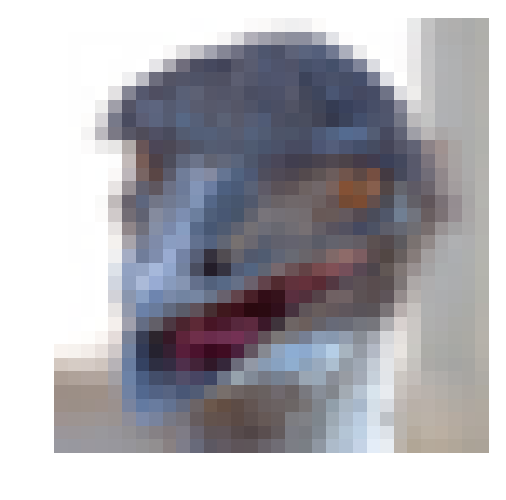

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 5

display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### Play around with the code cell by changing the batch_id and sample_id. The batch_id is the id for a batch (1-5). The sample_id is the id for an image and label pair in the batch


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


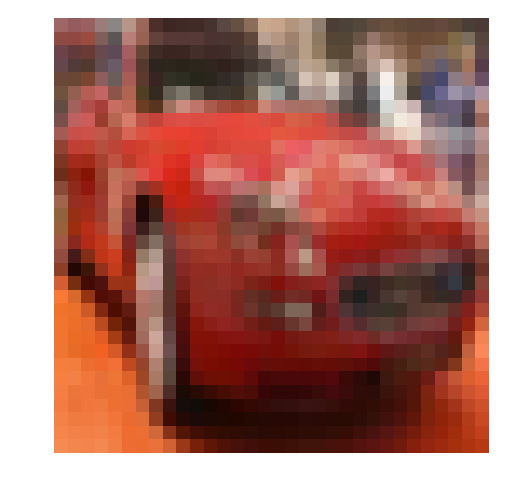

In [6]:
# Explore the dataset
display_stats(cifar10_dataset_folder_path, batch_id = 1, sample_id = 5)


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 10:
Image - Min Value: 4 Max Value: 231
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


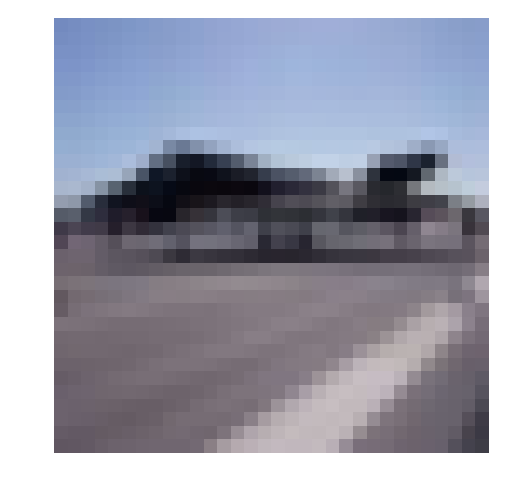

In [7]:
display_stats(cifar10_dataset_folder_path, batch_id = 2, sample_id = 10)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 15:
Image - Min Value: 59 Max Value: 210
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


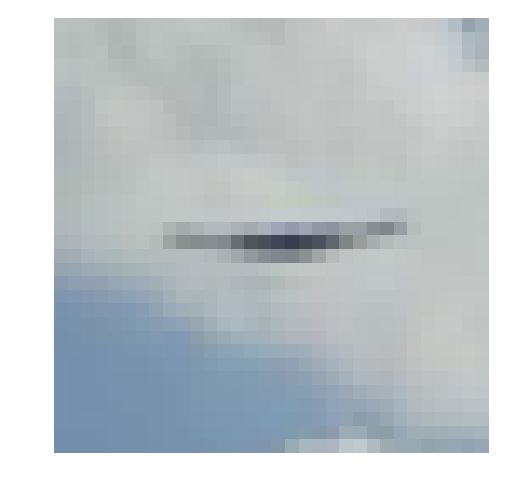

In [8]:
display_stats(cifar10_dataset_folder_path, batch_id = 3, sample_id = 15)


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 20:
Image - Min Value: 18 Max Value: 223
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


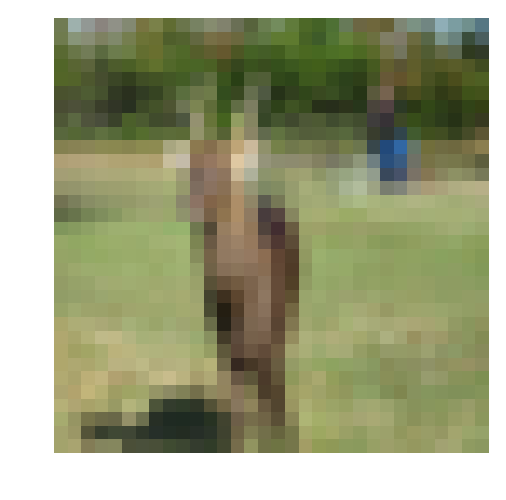

In [9]:
display_stats(cifar10_dataset_folder_path, batch_id = 4, sample_id = 20)


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 25:
Image - Min Value: 0 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


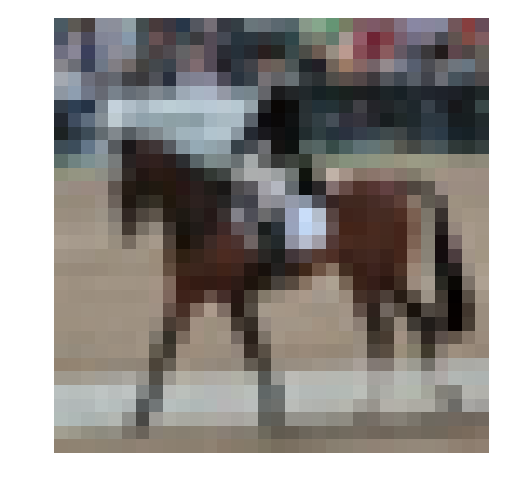

In [10]:
display_stats(cifar10_dataset_folder_path, batch_id = 5, sample_id = 25)

#### Based on the quick evaluation it is clear that:
(a) 10 possible labels - encoded 0 to 9 ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') <br>
(b) 5 possible batches - 1 to 5 <br>
(c) 10,000 images per batch - Image ID from 0 to 9999 <br>
(d) 5 batches of 10K images = 50K images total<br>

In [11]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    # return None
    a = 0
    b = 255
    return (x-a)/(b-a)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    # return None
    y = np.zeros((len(x), 10))
    for i in range(len(x)):
        y[i,x[i]] = 1
    return y

#### Pre-process the data and save it

In [12]:
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))



#### Create Neural Network

In [13]:
import tensorflow as tf

In [14]:


def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function    
    return tf.placeholder(tf.float32, [None] + list(image_shape), "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, None, "keep_prob")


#### Now, create Convolution and max pooling

In [15]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function    
    dimension = x_tensor.get_shape().as_list()
    shape = list(conv_ksize + (dimension[-1],) + (conv_num_outputs,))
    #print(shape)
    filter_weights = tf.Variable(tf.truncated_normal(shape,0,0.1)) # (height, width, input_depth, output_depth)
    filter_bias = tf.Variable(tf.zeros(conv_num_outputs))
    padding = 'SAME'
    #print(list((1,)+conv_strides+(1,)))
    #print(filter_weights)
    conv_layer = tf.nn.conv2d(x_tensor, filter_weights, list((1,)+conv_strides+(1,)), padding)
    conv_layer = tf.nn.bias_add(conv_layer, filter_bias)
    
    conv_layer = tf.nn.relu(conv_layer)
    
    conv_layer = tf.nn.max_pool(
        conv_layer,
        ksize=[1] + list(pool_ksize) + [1],
        strides=[1] + list(pool_strides) + [1],
        padding='SAME')
    
    return conv_layer

#### Flatten Layer

In [16]:
from numpy import prod
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    #return None
    dimension = x_tensor.get_shape().as_list()    
    return tf.reshape(x_tensor,[-1,prod(dimension[1:])])


#### Fully connected Layer



In [17]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    #return None
    dimension = x_tensor.get_shape().as_list()
    shape = list( (dimension[-1],) + (num_outputs,))
    #print(shape)
    weight = tf.Variable(tf.truncated_normal(shape,0,0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    return tf.nn.relu(tf.add(tf.matmul(x_tensor,weight), bias))


#### Output layer

In [18]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    # return None
    dimension = x_tensor.get_shape().as_list()
    shape = list( (dimension[-1],) + (num_outputs,))
    #print(shape)
    weight = tf.Variable(tf.truncated_normal(shape,0,0.01))
    bias = tf.Variable(tf.zeros(num_outputs))
    return tf.add(tf.matmul(x_tensor,weight), bias)


#### Create CNN model

In [25]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    model = conv2d_maxpool(x, conv_num_outputs=18, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(8,8), pool_strides=(1,1))
    #model = conv2d_maxpool(x, conv_num_outputs=36, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    #model = conv2d_maxpool(model, conv_num_outputs=8, conv_ksize=(4,4), conv_strides=(1,1), pool_ksize=(4,4), pool_strides=(1,1))
    #model = tf.nn.relu(model)
    model = tf.nn.dropout(model, keep_prob)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    model = flatten(model)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    model = fully_conn(model,384)
    #model = fully_conn(model,200)
    #model = fully_conn(model,20)
    #model = tf.nn.relu(model)
    
    model = tf.nn.dropout(model, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    model = output(model,10)
    
    # TODO: return output
    return model


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



#### Train the neural network

In [26]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    # pass
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


#### Show model statistics

In [27]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    # pass
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))

#### Hyperparameters

In [28]:
epochs = 100
batch_size = 512
keep_probability = 0.3

#### Train on a single CIFAR-10 batch

In [29]:
print('Checking the Training on a Single Batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2729 Validation Accuracy: 0.180000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0349 Validation Accuracy: 0.281400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8660 Validation Accuracy: 0.354400
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.7883 Validation Accuracy: 0.382400
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.7077 Validation Accuracy: 0.416800
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.6571 Validation Accuracy: 0.429800
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.6197 Validation Accuracy: 0.440800
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.5597 Validation Accuracy: 0.460400
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.5034 Validation Accuracy: 0.468400
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.4948 Validation Accuracy: 0.471400
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.4460 Validation Accuracy: 0.480600
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.4125 Validation Accuracy: 0.486200
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.3634

#### Fully Train the Model

In [31]:
save_model_path = './image_classification'

epochs = 50

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2826 Validation Accuracy: 0.113800
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.0710 Validation Accuracy: 0.329400
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7842 Validation Accuracy: 0.338400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6759 Validation Accuracy: 0.386800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.7137 Validation Accuracy: 0.386600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.7106 Validation Accuracy: 0.414200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.5837 Validation Accuracy: 0.428600
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.4612 Validation Accuracy: 0.443200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.4358 Validation Accuracy: 0.459600
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.5221 Validation Accuracy: 0.464800
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.5375 Validation Accuracy: 0.474800
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.4382 Validation Accuracy: 0.481400
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.2986 Validation Accuracy: 0.485600


Epoch 22, CIFAR-10 Batch 3:  Loss:     0.7838 Validation Accuracy: 0.658600
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.7720 Validation Accuracy: 0.660600
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.7727 Validation Accuracy: 0.661200
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.9052 Validation Accuracy: 0.666800
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.7923 Validation Accuracy: 0.665200
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.7900 Validation Accuracy: 0.653800
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.7670 Validation Accuracy: 0.667600
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.7696 Validation Accuracy: 0.661800
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.8886 Validation Accuracy: 0.663400
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.7861 Validation Accuracy: 0.662800
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.7498 Validation Accuracy: 0.666800
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.7633 Validation Accuracy: 0.664000
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.7355 Validation Accuracy: 0.665000
Epoch 25, CI

Epoch 43, CIFAR-10 Batch 5:  Loss:     0.5850 Validation Accuracy: 0.697600
Epoch 44, CIFAR-10 Batch 1:  Loss:     0.7020 Validation Accuracy: 0.693200
Epoch 44, CIFAR-10 Batch 2:  Loss:     0.6358 Validation Accuracy: 0.698200
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.5996 Validation Accuracy: 0.686600
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.6057 Validation Accuracy: 0.688800
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.5898 Validation Accuracy: 0.692200
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.6962 Validation Accuracy: 0.691800
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.6318 Validation Accuracy: 0.696200
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.5932 Validation Accuracy: 0.695000
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.5885 Validation Accuracy: 0.695200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.5590 Validation Accuracy: 0.701800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.6972 Validation Accuracy: 0.692600
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.6142 Validation Accuracy: 0.697800
Epoch 46, CI

#### Test the model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6907801002264022



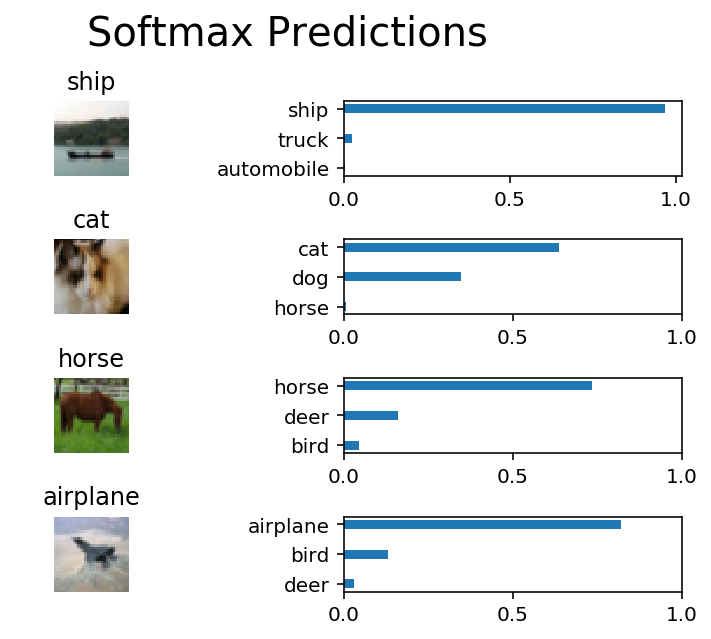

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
#import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

### RESULTS <BR>
    Overall model accuracy is 69%
    Single-batch training was 64%
    Training cross all 5 batches was 69.7%